# Sensor de Presión Sábana

En este notebook se hara el ejemplo de la adquisición de la matriz de presión de la sábana

### Inclusión de librerias

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
import time

# Inicializacion del MCP23017
from adafruit_mcp230xx.mcp23017 import MCP23017
import busio
import board
import digitalio

# Lectura del ADS1015
from adafruit_ads1x15.ads1015 import ADS1015
from adafruit_ads1x15.analog_in import AnalogIn


from scipy.ndimage import zoom

In [3]:
# Pines del shift register
DATA_PIN = 5
SHIFT_CLOCK_PIN = 13
LATCH_CLOCK_PIN = 6

GPIO.setmode(GPIO.BCM)
GPIO.setup(DATA_PIN, GPIO.OUT)
GPIO.setup(SHIFT_CLOCK_PIN, GPIO.OUT)
GPIO.setup(LATCH_CLOCK_PIN, GPIO.OUT)

In [40]:
def shift_register_out(val, bits=16):
    for i in range(bits-1, -1, -1):  # MSB first
        bit = (int(val) >> i) & 0x1
        GPIO.output(DATA_PIN, bit)
        GPIO.output(SHIFT_CLOCK_PIN, GPIO.HIGH)
        time.sleep(0.00001)
        GPIO.output(SHIFT_CLOCK_PIN, GPIO.LOW)
    GPIO.output(LATCH_CLOCK_PIN, GPIO.HIGH)
    time.sleep(0.00001)
    GPIO.output(LATCH_CLOCK_PIN, GPIO.LOW)

### Inicializacion del MCP23017

In [5]:
i2c = busio.I2C(board.SCL, board.SDA)
mcp = MCP23017(i2c, address=0x21)

# Usa pines GPA0-GPA3 para direcciones, GPA4 como enable
addr_pins = [mcp.get_pin(i) for i in range(4)]  # A0-A3
enable_pin = mcp.get_pin(4)

for pin in addr_pins:
    pin.direction = digitalio.Direction.OUTPUT
enable_pin.direction = digitalio.Direction.OUTPUT

In [43]:
# col_value debe ser un byte, ej: 0b00010000
def set_column(col_index):
    val = int(col_index)
    for i in range(4):
        addr_pins[i].value = (val >> i) & 1
    enable_pin.value = 1  # Activa la columna

### Lectura del ADS1015

In [7]:
# Crear objeto ADS1015 (en dirección 0x48)
ads = ADS1015(i2c, address=0x48)
chan = AnalogIn(ads, 0)  # O usar ADS1015.P0 (depende de la versión)

In [20]:
# Leer voltaje y valor en crudo
print(f"Voltaje: {chan.voltage:.3f} V")
print(f"Valor crudo: {chan.value}")

Voltaje: 0.000 V
Valor crudo: 0


## Bucle de adquisicion simplificado


In [82]:
ROW_SIZE = 16
COL_SIZE = 12
matrix = np.zeros((ROW_SIZE, COL_SIZE), dtype=int)
# 16 filas representadas por un solo bit en alto en un entero de 16 bits
rowArray = np.array([
    0b1000000000000000,
    0b0100000000000000,
    0b0010000000000000,
    0b0001000000000000,
    0b0000100000000000,
    0b0000010000000000,
    0b0000001000000000,
    0b0000000100000000,
    0b0000000010000000,
    0b0000000001000000,
    0b0000000000100000,
    0b0000000000010000,
    0b0000000000001000,
    0b0000000000000100,
    0b0000000000000010,
    0b0000000000000001
])
colArray = np.array([
    0b00010000,  # COL01
    0b00010001,  # COL02
    0b00010010,  # COL03
    0b00010011,  # COL04
    0b00010100,  # COL05
    0b00010101,  # COL06
    0b00010110,  # COL07
    0b00010111,  # COL08
    0b00011000,  # COL09
    0b00011001,  # COL10
    0b00011010,  # COL11
    0b00011011   # COL12
])



In [83]:
for i, val in enumerate(rowArray):
    print(f"rowArray[{i}] = {format(val, '016b')}")

rowArray[0] = 1000000000000000
rowArray[1] = 0100000000000000
rowArray[2] = 0010000000000000
rowArray[3] = 0001000000000000
rowArray[4] = 0000100000000000
rowArray[5] = 0000010000000000
rowArray[6] = 0000001000000000
rowArray[7] = 0000000100000000
rowArray[8] = 0000000010000000
rowArray[9] = 0000000001000000
rowArray[10] = 0000000000100000
rowArray[11] = 0000000000010000
rowArray[12] = 0000000000001000
rowArray[13] = 0000000000000100
rowArray[14] = 0000000000000010
rowArray[15] = 0000000000000001


In [36]:
for i, val in enumerate(colArray):
    print(f"colArray[{i}] = {format(val, '016b')}")

colArray[0] = 0000000000010000
colArray[1] = 0000000000010001
colArray[2] = 0000000000010010
colArray[3] = 0000000000010011
colArray[4] = 0000000000010100
colArray[5] = 0000000000010101
colArray[6] = 0000000000010110
colArray[7] = 0000000000010111
colArray[8] = 0000000000011000
colArray[9] = 0000000000011001
colArray[10] = 0000000000011010
colArray[11] = 0000000000011011


In [114]:
for i, row_idx in enumerate(rowArray):
    # print(f"Row: {row_idx}")
    shift_register_out(row_idx)  # Define rowArray como en el código original
    GPIO.output(LATCH_CLOCK_PIN, GPIO.HIGH)
    GPIO.output(LATCH_CLOCK_PIN, GPIO.LOW)

    for j, col_idx in enumerate(colArray):
        # print(f"Col: {col_idx}")
        set_column(col_idx)  # colArray también debe definirse
        time.sleep(0.02)  # espera corta para estabilidad
        matrix[i][j] = chan.value

In [95]:
print(matrix)

[[  32   32   48   32   16   16  752   32   32   32   64   32]
 [  32  112  176   32   16 2512  656 4832   32   32   32   32]
 [ 848   48   80 1280   64 3248 1344 3248  144  336  448   32]
 [  32  320   32 1168  160  672 3024 2144   64 2320  128   64]
 [  32    0   32 1168  464  288 1776 4160  208 1024   32   64]
 [  32 1408  672  832 4416  576 4064 6288 1632  752   32  368]
 [ 576 1056  928 1280  240   64 3136 3104  608   16   32   64]
 [2288 2912 1200 1600 2080  672 5136 4800   96  720 1056  720]
 [  16   16   32   32   32   32   32   32   32   48   32    0]
 [ 272  848  128 1568 5856  832 1472  768  288  784  384  448]
 [ 608  544  752  432 3392 4016 1008 1472  416  624   32   32]
 [  48 2160 1280 1312 3376  384  224  688 1600  576   32    0]
 [  32   48   64 2272 1984 1360   96  224 1376   80   64   32]
 [  48  384   32  960  512 5968  144   96 1264   32   32  288]
 [  32 2176 1120 1504 1616 1168   32  240 3248  560   32   32]
 [  16   32  672 1104  208   64   32   32   48   32   1

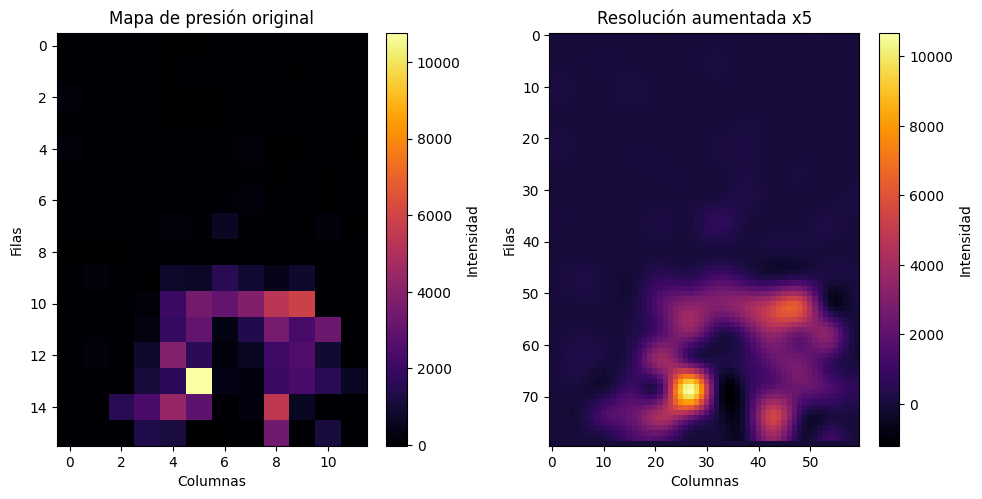

In [115]:
# Asegúrate de que 'matrix' ya esté definido correctamente
matrix_im = np.array(matrix, dtype=float)  # mejor especificar dtype explícitamente

zoom_factor = 5

# Aplicar interpolación
resampled = zoom(matrix_im, zoom=zoom_factor, order=3)  # order=3: bicubic

# Mostrar la imagen
plt.figure(figsize=(10, 5))  # <- corregido aquí
plt.subplot(1, 2, 1)
plt.imshow(matrix_im, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Intensidad')
plt.title("Mapa de presión original")
plt.xlabel("Columnas")
plt.ylabel("Filas")

plt.subplot(1, 2, 2)
plt.imshow(resampled, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Intensidad')
plt.title(f"Resolución aumentada x{zoom_factor}")
plt.xlabel("Columnas")
plt.ylabel("Filas")

plt.tight_layout()
plt.show()


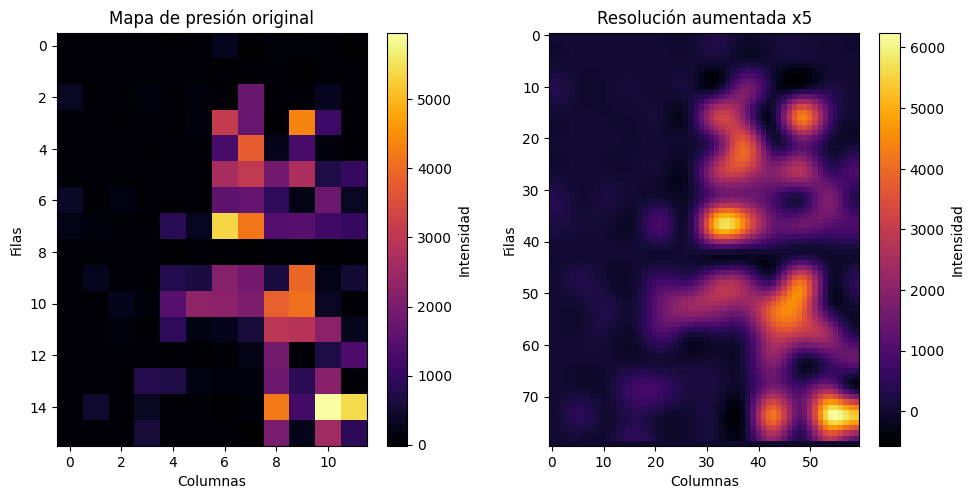

In [140]:
for i, row_idx in enumerate(rowArray):
    # print(f"Row: {row_idx}")
    shift_register_out(row_idx)  # Define rowArray como en el código original
    GPIO.output(LATCH_CLOCK_PIN, GPIO.HIGH)
    GPIO.output(LATCH_CLOCK_PIN, GPIO.LOW)

    for j, col_idx in enumerate(colArray):
        # print(f"Col: {col_idx}")
        set_column(col_idx)  # colArray también debe definirse
        time.sleep(0.02)  # espera corta para estabilidad
        matrix[i][j] = chan.value

# Asegúrate de que 'matrix' ya esté definido correctamente
matrix_im = np.array(matrix, dtype=float)  # mejor especificar dtype explícitamente

zoom_factor = 5

# Aplicar interpolación
resampled = zoom(matrix_im, zoom=zoom_factor, order=3)  # order=3: bicubic

# Mostrar la imagen
plt.figure(figsize=(10, 5))  # <- corregido aquí
plt.subplot(1, 2, 1)
plt.imshow(matrix_im, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Intensidad')
plt.title("Mapa de presión original")
plt.xlabel("Columnas")
plt.ylabel("Filas")

plt.subplot(1, 2, 2)
plt.imshow(resampled, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Intensidad')
plt.title(f"Resolución aumentada x{zoom_factor}")
plt.xlabel("Columnas")
plt.ylabel("Filas")

plt.tight_layout()
plt.show()


# Creacion de una animacion

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import time

import imageio.v2 as imageio
import matplotlib.animation as animation

### Definicion de funciones

In [146]:
ROW_SIZE = 16
COL_SIZE = 12
matrix = np.zeros((ROW_SIZE, COL_SIZE), dtype=int)
# 16 filas representadas por un solo bit en alto en un entero de 16 bits
rowArray = np.array([
    0b1000000000000000,
    0b0100000000000000,
    0b0010000000000000,
    0b0001000000000000,
    0b0000100000000000,
    0b0000010000000000,
    0b0000001000000000,
    0b0000000100000000,
    0b0000000010000000,
    0b0000000001000000,
    0b0000000000100000,
    0b0000000000010000,
    0b0000000000001000,
    0b0000000000000100,
    0b0000000000000010,
    0b0000000000000001
])
colArray = np.array([
    0b00010000,  # COL01
    0b00010001,  # COL02
    0b00010010,  # COL03
    0b00010011,  # COL04
    0b00010100,  # COL05
    0b00010101,  # COL06
    0b00010110,  # COL07
    0b00010111,  # COL08
    0b00011000,  # COL09
    0b00011001,  # COL10
    0b00011010,  # COL11
    0b00011011   # COL12
])


def read_matrix(zoom_factor = 5):
    for i, row_idx in enumerate(rowArray):
        # print(f"Row: {row_idx}")
        shift_register_out(row_idx)  # Define rowArray como en el código original
        GPIO.output(LATCH_CLOCK_PIN, GPIO.HIGH)
        GPIO.output(LATCH_CLOCK_PIN, GPIO.LOW)
    
        for j, col_idx in enumerate(colArray):
            # print(f"Col: {col_idx}")
            set_column(col_idx)  # colArray también debe definirse
            time.sleep(0.005)  # espera corta para estabilidad
            matrix[i][j] = chan.value

        matrix_im = np.array(matrix, dtype=float)
        
        # Aplicar interpolación
        resampled = zoom(matrix_im, zoom=zoom_factor, order=3)  # order=3: bicubic

    return matrix_im, resampled


## Muestreo de la animacion

In [148]:
frames = []
duration_sec = 60         # duración total: 2 minutos
interval = 2               # cada 2 segundos
zoom_factor = 5

start_time = time.time()

contador = 0

while (contador) < duration_sec:
    # Simula una lectura desde tu sensor — reemplaza con tu función real
    matrix, resampled = read_matrix()  # ← define esta función con tu adquisición real

    frames.append(resampled)
    
    print(f"Captura #{len(frames)} hecha a los {round(time.time() - start_time)} segundos")
    
    contador = contador + 1


Captura #1 hecha a los 3 segundos
Captura #2 hecha a los 6 segundos
Captura #3 hecha a los 9 segundos
Captura #4 hecha a los 12 segundos
Captura #5 hecha a los 15 segundos
Captura #6 hecha a los 18 segundos
Captura #7 hecha a los 21 segundos
Captura #8 hecha a los 24 segundos
Captura #9 hecha a los 27 segundos
Captura #10 hecha a los 30 segundos
Captura #11 hecha a los 32 segundos
Captura #12 hecha a los 36 segundos
Captura #13 hecha a los 39 segundos
Captura #14 hecha a los 42 segundos
Captura #15 hecha a los 46 segundos
Captura #16 hecha a los 48 segundos
Captura #17 hecha a los 51 segundos
Captura #18 hecha a los 54 segundos
Captura #19 hecha a los 57 segundos
Captura #20 hecha a los 60 segundos
Captura #21 hecha a los 63 segundos
Captura #22 hecha a los 66 segundos
Captura #23 hecha a los 69 segundos
Captura #24 hecha a los 72 segundos
Captura #25 hecha a los 75 segundos
Captura #26 hecha a los 78 segundos
Captura #27 hecha a los 81 segundos
Captura #28 hecha a los 84 segundos
Capt

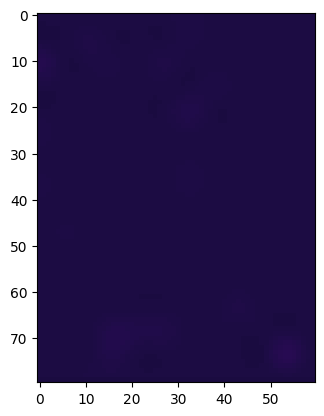

In [150]:
all_data = np.array(frames)
vmin = np.min(all_data)
vmax = np.max(all_data)

fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='inferno', animated=True, vmin=vmin, vmax=vmax)

def update(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=interval*1000, blit=True)

# Guardar como MP4 (requiere ffmpeg instalado)
ani.save("presion_animacion.mp4", fps=1/interval)

# O mostrar directamente
plt.show()

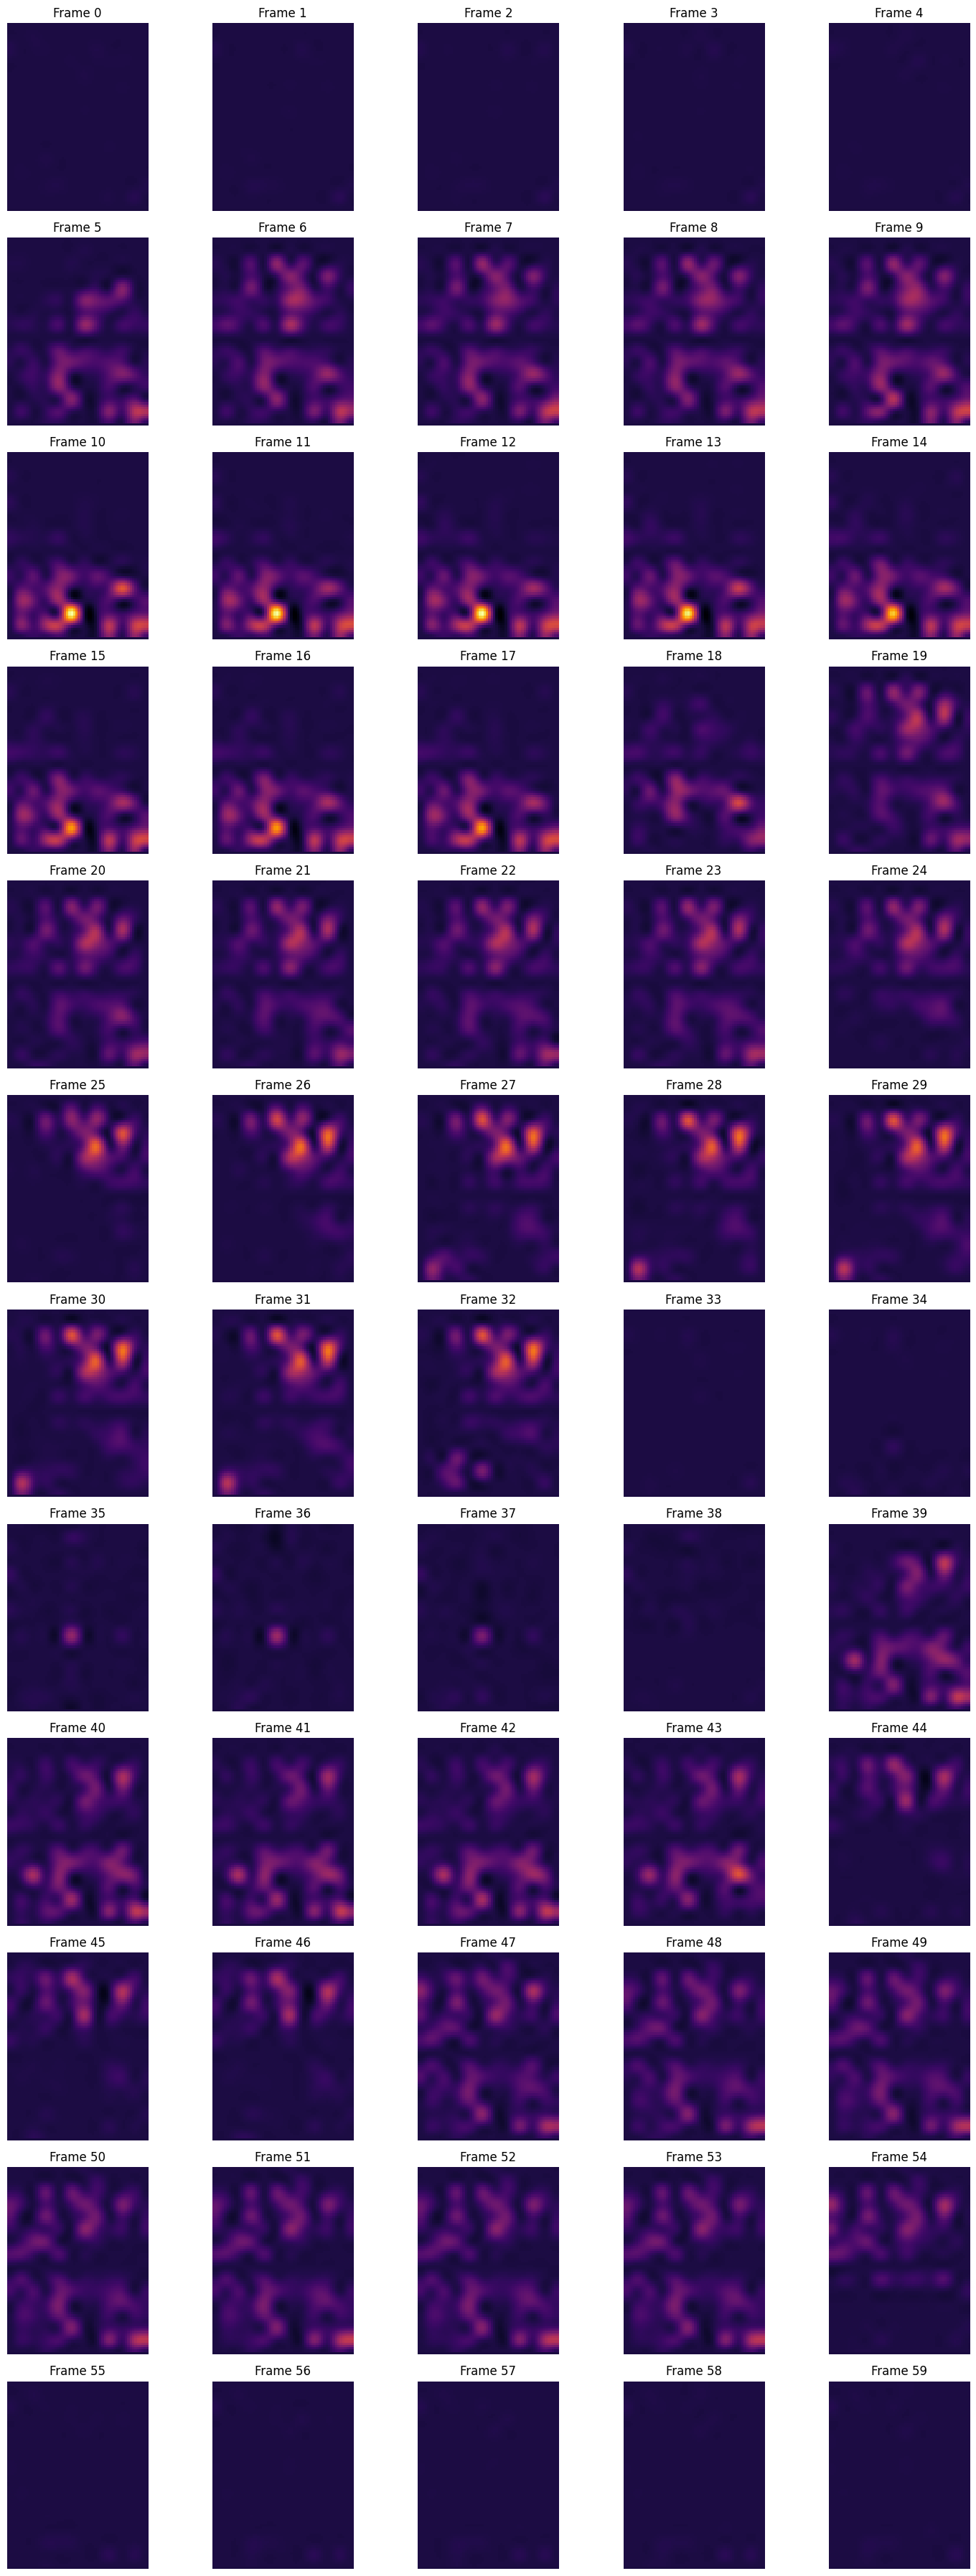

In [151]:
n_frames = len(frames)
cols = 5
rows = (n_frames + cols - 1) // cols  # calcular filas necesarias

plt.figure(figsize=(cols * 3, rows * 3))
for i, frame in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(frame, cmap='inferno', vmin=vmin, vmax=vmax)
    plt.title(f"Frame {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()